In [253]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import make_scorer, confusion_matrix
from sklearn.model_selection import learning_curve
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns
import re
import unicodedata
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.corpus import words
import unicodedata
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

In [95]:
sa_df = pd.read_csv('sentiment_analysis.csv')
sa_df

ID                                               text  label
0       7.680000e+17  Josh Jenkins is looking forward to TAB Breeder...      1
1       7.680000e+17  RT @MianUsmanJaved: Congratulations Pakistan o...      1
2       7.680000e+17  RT @PEPalerts: This September, @YESmag is taki...      1
3       7.680000e+17  RT @david_gaibis: Newly painted walls, thanks ...      1
4       7.680000e+17  RT @CedricFeschotte: Excited to announce: as o...      1
...              ...                                                ...    ...
550386  8.050000e+17  @goddesses_o I can't stop watching her...mm. M...      0
550387  8.050000e+17  Poor old Tom Odell doesn't look like he would ...      0
550388  8.050000e+17  #antsmasher I smashed  7 ants in this awesome ...      1
550389  8.050000e+17  @LizHudston @KymWyllie @Evasmiless @meanBok @l...      1
550390  8.050000e+17  Bixbeat Mixtape Vol.2 is here with great artis...      1

[550391 rows x 3 columns]

In [96]:
ce_df = pd.read_csv('Canadian_elections_2021.csv')
ce_df

text sentiment  \
0     The Canadian election is a power grab by PM Tr...  negative   
1     I do hope Trudeau loses the Canadian election ...  negative   
2     Dear Canadians, This election is a test of how...  positive   
3     Canadian friends: Never forget that Trudeau ha...  negative   
4     Sorry @theJagmeetSingh I have voted #NDP all m...  positive   
...                                                 ...       ...   
997   This is absolutely horrible in Canada. The for...  negative   
998   @davidakin Trudeau imposes gun control policie...  negative   
999   In Canada 🇨🇦 our election is being stolen by t...  negative   
1000  O'Toole amends platform on gun control, but qu...  negative   
1001  @JustinTrudeau STOP YOUR LIES, STOP YOUR MANIP...  negative   

             negative_reason  
0     calling election early  
1                     covid   
2                        NaN  
3     calling election early  
4                        NaN  
...                      ...  
997                   others  
998              gun control  
999                   others  
1000               tell lies  
1001               tell lies  

[1002 rows x 3 columns]

# 1. Data cleaning

In [97]:
#remove html
def cleanhtml(raw_html):
    CLEANR = re.compile('<.*?>|&([a-z0-9]+|#[0-9]{1,6}|#x[0-9a-f]{1,6});')
    cleantext = re.sub(CLEANR, '', raw_html)
    return cleantext

sa_df.text = sa_df.text.apply(cleanhtml)
ce_df.text = ce_df.text.apply(cleanhtml)

In [98]:
#remove emoji
def removeemoji(text):
    emoji_pattern = re.compile("["
            u"\U0001F600-\U0001F64F"  # emoticons
            u"\U0001F300-\U0001F5FF"  # symbols & pictographs
            u"\U0001F680-\U0001F6FF"  # transport & map symbols
            u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                               "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

sa_df.text = sa_df.text.apply(removeemoji)
ce_df.text = ce_df.text.apply(removeemoji)

In [99]:
#Replace html character by an ASCII equivalent
def asciiconvert(text):
    cleantext = unicodedata.normalize('NFKD', text).encode('ascii','ignore').decode('utf-8')
    return cleantext

sa_df.text = sa_df.text.apply(asciiconvert)
ce_df.text = ce_df.text.apply(asciiconvert)

In [100]:
#remove all URLs
def removeURL(text):
    cleantext = re.sub(r"http\S+", "", text)
    return cleantext

sa_df.text = sa_df.text.apply(removeURL)
ce_df.text = ce_df.text.apply(removeURL)

In [101]:
#Lowercase
def LOWER(text):
    return text.lower()

sa_df.text = sa_df.text.apply(LOWER)
ce_df.text = ce_df.text.apply(LOWER)

In [102]:
#remove all symbols like !, @, #, etc.
def removesymbol(text):
    cleantext = re.sub(r'[^a-zA-Z]', ' ', text)
    return cleantext

sa_df.text = sa_df.text.apply(removesymbol)
ce_df.text = ce_df.text.apply(removesymbol)

In [122]:
#Replace all words with their base form
w_tokenizer = nltk.tokenize.WhitespaceTokenizer()
lemmatizer = nltk.stem.WordNetLemmatizer()

def lemmatize_text(text):
    w_tokenizer = nltk.tokenize.WhitespaceTokenizer()
    lemmatizer = nltk.stem.WordNetLemmatizer()
    return [lemmatizer.lemmatize(w) for w in w_tokenizer.tokenize(text)]

sa_df.text = sa_df.text.apply(lemmatize_text)
ce_df.text = ce_df.text.apply(lemmatize_text)

In [91]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Eric\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [118]:
#Remove stop words
def removestopwords(text):
    stop_words = set(stopwords.words('english'))
    filtered_sentence = [w for w in text if not w.lower() in stop_words]
    return filtered_sentence

sa_df.text = sa_df.text.apply(removestopwords)
ce_df.text = ce_df.text.apply(removestopwords)

In [123]:
sa_df

ID                                               text  label
0       7.680000e+17  [josh, jenkins, is, looking, forward, to, tab,...      1
1       7.680000e+17  [rt, mianusmanjaved, congratulation, pakistan,...      1
2       7.680000e+17  [rt, pepalerts, this, september, yesmag, is, t...      1
3       7.680000e+17  [rt, david, gaibis, newly, painted, wall, than...      1
4       7.680000e+17  [rt, cedricfeschotte, excited, to, announce, a...      1
...              ...                                                ...    ...
550386  8.050000e+17  [goddess, o, i, can, t, stop, watching, her, m...      0
550387  8.050000e+17  [poor, old, tom, odell, doesn, t, look, like, ...      0
550388  8.050000e+17  [antsmasher, i, smashed, ant, in, this, awesom...      1
550389  8.050000e+17  [lizhudston, kymwyllie, evasmiless, meanbok, l...      1
550390  8.050000e+17  [bixbeat, mixtape, vol, is, here, with, great,...      1

[550391 rows x 3 columns]

In [120]:
ce_df

text sentiment  \
0     [canadian, election, power, grab, pm, trudeau,...  negative   
1     [hope, trudeau, loses, canadian, election, tom...  negative   
2     [dear, canadian, election, test, progressive, ...  positive   
3     [canadian, friend, never, forget, trudeau, yea...  negative   
4     [sorry, thejagmeetsingh, voted, ndp, life, ele...  positive   
...                                                 ...       ...   
997   [absolutely, horrible, canada, forthcoming, el...  negative   
998   [davidakin, trudeau, imposes, gun, control, po...  negative   
999   [canada, election, stolen, thug, uneducated, g...  negative   
1000  [toole, amends, platform, gun, control, questi...  negative   
1001  [justintrudeau, stop, lie, stop, manipulation,...  negative   

             negative_reason  
0     calling election early  
1                     covid   
2                        NaN  
3     calling election early  
4                        NaN  
...                      ...  
997                   others  
998              gun control  
999                   others  
1000               tell lies  
1001               tell lies  

[1002 rows x 3 columns]

# 2. Exploratory analysis

Relevant keywords:
Liberal: Liberal, Trudean, JustinTrudean, health, care, pension, loans, multiculture
Conservative: Conservative, ErinOToole, budget, tax, gun, control
New Democratic Party: NewDemocraticParty, NDP, JagmeetSingh, Singh, NewDemocratic, minority, LGBT, environment, international
People's Party of Canada: People, MaximeBernier, immigration, Paris, lockdown, vaccine, vaccination

In [138]:
liberal = ['trudean', 'justintrudeau', 'liberal', 'health', 'care', 'pension', 'loans', 'multiculture']
conservative = ['otoole', 'erinotoole', 'conservative', 'erin', 'gun', 'control', 'budget', 'tax']
NDP = ['singh', 'jagmeetsingh', 'minority', 'ndp', 'newdemocratic', 'lgbt', 'environment', 'international']
PPC = ['bernier', 'maximebernier', 'ppc', 'immigration', 'paris', 'lockdown', 'vaccine', 'vaccineation']

In [159]:
ce_df['party'] = 'NaN'
l_list = []
c_list = []
n_list = []
p_list = []
l_df = pd.DataFrame(None, columns=['text', 'sentiment', 'negative_reason'])
c_df = pd.DataFrame(None, columns=['text', 'sentiment', 'negative_reason'])
n_df = pd.DataFrame(None, columns=['text', 'sentiment', 'negative_reason'])
p_df = pd.DataFrame(None, columns=['text', 'sentiment', 'negative_reason'])
other_df = pd.DataFrame(None, columns=['text', 'sentiment', 'negative_reason'])

for i in range(ce_df.shape[0]):
    l_list = []
    c_list = []
    n_list = []
    p_list = []
    election_list = ce_df['text'][i]

    for l in liberal:
        for j in election_list:
            if l in j:
                l_list.append(j)
    for c in conservative:
        for j in election_list:
             if c in j:
                c_list.append(j)
    for n in NDP:
        for j in election_list:
            if n in j:
                n_list.append(j)
    for p in PPC:
        for j in election_list:
            if p in j:
                p_list.append(j)

    if len(l_list) > max([len(c_list), len(n_list), len(p_list)]):
        l_df = l_df.append(ce_df.iloc[i], ignore_index=True)
        ce_df['party'][i] = 'Liberal'
    elif len(c_list) > max([len(l_list), len(n_list), len(p_list)]):
        c_df = c_df.append(ce_df.iloc[i], ignore_index=True)
        ce_df['party'][i] = 'Conservative'
    elif len(n_list) > max([len(l_list), len(c_list), len(p_list)]):
        n_df = n_df.append(ce_df.iloc[i], ignore_index=True)
        ce_df['party'][i] = 'NDP'
    elif len(p_list) > max([len(l_list), len(n_list), len(c_list)]):
        p_df = p_df.append(ce_df.iloc[i], ignore_index=True)
        ce_df['party'][i] = 'PPC'
    else:
        other_df = other_df.append(ce_df.iloc[i], ignore_index=True) 
        ce_df['party'][i] = 'Other'

In [160]:
print('Liberal Party has {:.2%}'.format(l_df.shape[0]/ce_df.shape[0]),'tweets')

Liberal Party has 15.57% tweets


In [161]:
print('Conservative Party has {:.2%}'.format(c_df.shape[0]/ce_df.shape[0]),'tweets')

Conservative Party has 28.04% tweets


In [162]:
print('New Democratic Party has {:.2%}'.format(n_df.shape[0]/ce_df.shape[0]),'tweets')

New Democratic Party has 5.49% tweets


In [163]:
print("People's Party has {:.2%}".format(p_df.shape[0]/ce_df.shape[0]),'tweets')

People's Party has 7.49% tweets


In [165]:
print('Other has {:.2%}'.format(other_df.shape[0]/ce_df.shape[0]),'tweets')

Other has 43.41% tweets


Distribution of the political affiliations of the tweets: Conservative Party is the most popular one and it has 28.57% tweets while Liberal Party only has 15.57% tweets, approximately half of the number of Consevative Party's tweets. People's Party and New Demcratic Party share 7.49% and 5.49% tweets correspondingly. The rest 43.42% tweets do not have obivous political leanings.

In [173]:
#2.2
#Positive sentiments are labelled with 1
#Negative sentiments are labelled with 0
positive_df = sa_df.loc[sa_df['label'] == 1]
negative_df = sa_df.loc[sa_df['label'] == 0]
positive_cnt = positive_df.shape[0]
negative_cnt = negative_df.shape[0]

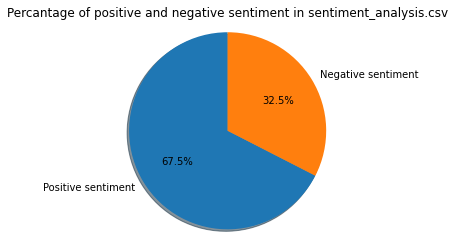

In [174]:
labels = ['Positive sentiment', 'Negative sentiment']
sizes = [positive_cnt, negative_cnt]
fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.title('Percantage of positive and negative sentiment in sentiment_analysis.csv')
plt.show()

Findings: Most tweets have positive sentiment, which occupy 67.5% out of all tweets and only 32.5% tweets have negative sentiment

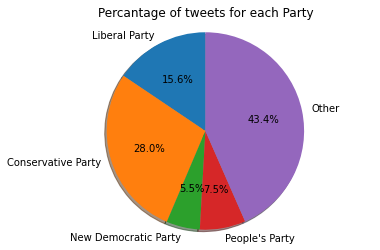

In [175]:
labels = 'Liberal Party', 'Conservative Party', 'New Democratic Party', "People's Party", 'Other'
sizes = [l_df.shape[0]/ce_df.shape[0], c_df.shape[0]/ce_df.shape[0], n_df.shape[0]/ce_df.shape[0], 
         p_df.shape[0]/ce_df.shape[0], other_df.shape[0]/ce_df.shape[0]]
fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  
plt.title('Percantage of tweets for each Party')
plt.show()

Finding: From the pie chart, we can observe that most tweets are political related. And among four Parties, Conservative Partty concentrates the most attention while Liberal Party is a little behind. Only small number of tweets are talking about New Democratic Party and People's Party. 

# 3. Model Preparation

In [188]:
#Set up Y data
Y = sa_df['label']

In [192]:
# Combine elements in each list into a string
def combine_list(text):
    return " ".join(text)
str_sentiments = sa_df['text'].apply(combine_list)

def bag_of_words(text):
    count = CountVectorizer()
    sentiments = count.fit_transform(text)
    #bag_of_words.toarray()
    feature_names = count.get_feature_names()
    return sentiments

X_bw = bag_of_words(str_sentiments)
X_bw

<550391x324661 sparse matrix of type '<class 'numpy.int64'>'
	with 5998228 stored elements in Compressed Sparse Row format>

In [199]:
#Split the generic tweets by bag of words features
X_train_bw, X_test_bw, y_train_bw, y_test_bw = train_test_split(X_bw, Y, test_size = 0.30, random_state = 42)

In [200]:
# Calculate TF-IDF score and return them in order
def tf_idf(text):
    v = TfidfVectorizer()
    sentiments = v.fit_transform(text)
    return sentiments

X_ti = tf_idf(str_sentiments)
X_ti

<550391x324661 sparse matrix of type '<class 'numpy.float64'>'
	with 5998228 stored elements in Compressed Sparse Row format>

In [212]:
#Split the generic tweets by TF-IDF features
X_train_ti, X_test_ti, y_train_ti, y_test_ti = train_test_split(X_ti, Y, test_size = 0.30, random_state = 42)

# logistic regression

In [285]:
#we will use default hyperparameter for the model
#Bag of words
bw_logi = LogisticRegression()
bw_logi.fit(X_train_bw, y_train_bw)
bw_logi_pred = bw_logi.predict(X_test_bw)
bw_logi_acc = accuracy_score(y_test_bw, bw_logi_pred)
print('The accuracy for bag of words by logistic regression is', bw_logi_acc)

The accuracy for bag of words by logistic regression is 0.9792209207960367


In [274]:
#TF-IDF
ti_logi = LogisticRegression()
ti_logi.fit(X_train_ti, y_train_ti)
ti_logi_pred = ti_logi.predict(X_test_ti)
ti_logi_acc = accuracy_score(y_test_ti, ti_logi_pred)
print('The accuracy for TF-IDF by logistic regression is', ti_logi_acc)

The accuracy for bTF-IDF by logistic regression is 0.9765924974866459


# k-NN

In [247]:
#bag of words
bw_knn = KNeighborsClassifier()
bw_knn.fit(X_train_bw, y_train_bw)
bw_knn_pred = bw_knn.predict(X_test_bw)
bw_knn_acc = accuracy_score(y_test_bw, bw_knn_pred)
print('The accuracy for bag of words by KNN is', bw_knn_acc)

The accuracy for bag of words by KNN is 0.8894366453082039


In [248]:
#TF-IDF
ti_knn = KNeighborsClassifier()
ti_knn.fit(X_train_ti, y_train_ti)
ti_knn_pred = ti_knn.predict(X_test_ti)
ti_knn_acc = accuracy_score(y_test_ti, ti_knn_pred)
print('The accuracy for TF-IDF by KNN is', ti_knn_acc)

The accuracy for bTF-IDF by KNN is 0.8784142249785002


# Naive Bayes

In [240]:
#bag of words
bw_nb = MultinomialNB()
bw_nb.fit(X_train_bw, y_train_bw)
bw_nb_pred = bw_nb.predict(X_test_bw)
bw_nb_acc = accuracy_score(y_test_bw, bw_nb_pred)
print('The accuracy for bag of words by Naives Bayers is', bw_nb_acc)

The accuracy for bag of words by Naives Bayers is 0.952385566685643


In [241]:
#TF-IDF
ti_nb = MultinomialNB()
ti_nb.fit(X_train_ti, y_train_ti)
ti_nb_pred = ti_nb.predict(X_test_ti)
ti_nb_acc = accuracy_score(y_test_ti, ti_nb_pred)
print('The accuracy for TF-IDF by Naives Bayers is', ti_nb_acc)

The accuracy for bTF-IDF by Naives Bayers is 0.9128804854709965


# SVM

In [254]:
#bag of words
bw_svm = LinearSVC()
bw_svm.fit(X_train_bw, y_train_bw)
bw_svm_pred = bw_svm.predict(X_test_bw)
bw_svm_acc = accuracy_score(y_test_bw, bw_svm_pred)
print('The accuracy for bag of words by svm is', bw_svm_acc)

The accuracy for bag of words by svm is 0.9773071379256048


In [255]:
#TF-IDF
ti_svm = LinearSVC()
ti_svm.fit(X_train_ti, y_train_ti)
ti_svm_pred = ti_svm.predict(X_test_ti)
ti_svm_acc = accuracy_score(y_test_ti, ti_svm_pred)
print('The accuracy for TF-IDF by svm is', ti_svm_acc)

The accuracy for bTF-IDF by svm is 0.9798083794619605


# decision trees

In [238]:
#bag of words
bw_dtc = DecisionTreeClassifier()
bw_dtc.fit(X_train_bw, y_train_bw)
bw_dtc_pred = bw_dtc.predict(X_test_bw)
bw_dtc_acc = accuracy_score(y_test_bw, bw_dtc_pred)
print('The accuracy for bag of words by Decision Trees is', bw_dtc_acc)

The accuracy for bag of words by Decision Trees is 0.9480008236533872


In [239]:
#TF-IDF
ti_dtc = DecisionTreeClassifier()
ti_dtc.fit(X_train_ti, y_train_ti)
ti_dtc_pred = ti_dtc.predict(X_test_ti)
ti_dtc_acc = accuracy_score(y_test_ti, ti_dtc_pred)
print('The accuracy for TF-IDF by Decision Trees is', ti_dtc_acc)

The accuracy for bTF-IDF by Decision Trees is 0.9428408774331084


# Random Forest

In [236]:
#bag of words
bw_rfc = RandomForestClassifier()
bw_rfc.fit(X_train_bw, y_train_bw)
bw_rfc_pred = bw_rfc.predict(X_test_bw)
bw_rfc_acc = accuracy_score(y_test_bw, bw_rfc_pred)
print('The accuracy for bag of words by random forest is', bw_rfc_acc)

The accuracy for bag of words by random forest is 0.9625903899029785


In [237]:
#TF-IDF
ti_rfc = RandomForestClassifier()
ti_rfc.fit(X_train_ti, y_train_ti)
ti_rfc_pred = ti_rfc.predict(X_test_ti)
ti_rfc_acc = accuracy_score(y_test_ti, ti_rfc_pred)
print('The accuracy for TF-IDF by random forest is', ti_rfc_acc)

The accuracy for bTF-IDF by by random forest is 0.96075533860633


# XGBoost

In [233]:
#bag of words
bw_xgb = xgb.XGBClassifier()
bw_xgb.fit(X_train_bw, y_train_bw)
bw_xgb_pred = bw_xgb.predict(X_test_bw)
bw_xgb_acc = accuracy_score(y_test_bw, bw_xgb_pred)
print('The accuracy for bag of words by XGBoost is', bw_xgb_acc)

The accuracy for bag of words by XGBoost is 0.8605542702794365


In [235]:
#TF-IDF
ti_xgb = xgb.XGBClassifier()
ti_xgb.fit(X_train_ti, y_train_ti)
ti_xgb_pred = ti_xgb.predict(X_test_ti)
ti_xgb_acc = accuracy_score(y_test_ti, ti_xgb_pred)
print('The accuracy for TF-IDF by XGBoost is', ti_xgb_acc)

The accuracy for bTF-IDF by by XGBoost is 0.8606330018532201


# 4. Model implementation and tuning

In [306]:
#a)
#a. 
ce_sentiment = ce_df['text'].apply(combine_list)
X_bw_ce = bag_of_words(ce_sentiment)
#new x_test
X_bw_ce

<1002x4098 sparse matrix of type '<class 'numpy.int64'>'
	with 24435 stored elements in Compressed Sparse Row format>

In [316]:
#transfer negative and positive in Canadian Election into 0 and 1
ce_df['sentiment_num'] = ce_df.sentiment.replace({'negative': 0, 'positive': 1})
ce_df

text sentiment  \
0     [the, canadian, election, is, a, power, grab, ...  negative   
1     [i, do, hope, trudeau, loses, the, canadian, e...  negative   
2     [dear, canadian, this, election, is, a, test, ...  positive   
3     [canadian, friend, never, forget, that, trudea...  negative   
4     [sorry, thejagmeetsingh, i, have, voted, ndp, ...  positive   
...                                                 ...       ...   
997   [this, is, absolutely, horrible, in, canada, t...  negative   
998   [davidakin, trudeau, imposes, gun, control, po...  negative   
999   [in, canada, our, election, is, being, stolen,...  negative   
1000  [o, toole, amends, platform, on, gun, control,...  negative   
1001  [justintrudeau, stop, your, lie, stop, your, m...  negative   

             negative_reason         party  sentiment_num  
0     calling election early         Other              0  
1                     covid          Other              0  
2                        NaN       Liberal              1  
3     calling election early           PPC              0  
4                        NaN           PPC              1  
...                      ...           ...            ...  
997                   others         Other              0  
998              gun control  Conservative              0  
999                   others         Other              0  
1000               tell lies  Conservative              0  
1001               tell lies         Other              0  

[1002 rows x 5 columns]

In [319]:
#reconstruct the logistic regression model and fit in new data
y_ce = ce_df.sentiment_num
X_train_bw_ce, X_test_bw_ce, y_train_bw_ce, y_test_bw_ce = train_test_split(X_bw_ce, y_ce, test_size = 0.30, random_state = 42)
bw_logi_ce = LogisticRegression()
bw_logi_ce.fit(X_train_bw_ce, y_train_bw_ce)
bw_logi_pred_ce = bw_logi_ce.predict(X_bw_ce)
bw_logi_acc_ce = accuracy_score(y_bw_ce, bw_logi_pred_ce)
print('The accuracy for bag of words by logistic regression on Canadian Election data is', bw_logi_acc_ce)

The accuracy for bag of words by logistic regression on Canadian Election data is 0.9291417165668663


The best performance trained model is logistic regression for bag of words with accuracy is 0.9792209207960367. It also did well on predicting sentiment in the Canadian Elections data with accuracy of 0.9291417165668663

In [400]:
#b. 
from sklearn.metrics import recall_score,precision_score,f1_score
print('Precision Score : ' + str(precision_score(y_bw_ce, bw_logi_pred_ce)))
print('Recall Score : ' + str(recall_score(y_bw_ce, bw_logi_pred_ce)))
print('F1 Score : ' + str(f1_score(y_bw_ce, bw_logi_pred_ce)))

Precision Score : 0.9358974358974359
Recall Score : 0.9495934959349593
F1 Score : 0.9426957223567394


Precision score: Precision is the fraction of true positive examples among the examples that the model classified as positive. In other words, the number of true positives divided by the number of false positives plus true positives.

Recall score: known as sensitivity, is the fraction of examples classified as positive, among the total number of positive examples. In other words, the number of true positives divided by the number of true positives plus false negatives.

The F-score is commonly used for evaluating information retrieval systems such as search engines, and also for many kinds of machine learning models, in particular in natural language processing.

In [320]:
#c
ce_df['predict'] = bw_logi_pred_ce
ce_df

text sentiment  \
0     [the, canadian, election, is, a, power, grab, ...  negative   
1     [i, do, hope, trudeau, loses, the, canadian, e...  negative   
2     [dear, canadian, this, election, is, a, test, ...  positive   
3     [canadian, friend, never, forget, that, trudea...  negative   
4     [sorry, thejagmeetsingh, i, have, voted, ndp, ...  positive   
...                                                 ...       ...   
997   [this, is, absolutely, horrible, in, canada, t...  negative   
998   [davidakin, trudeau, imposes, gun, control, po...  negative   
999   [in, canada, our, election, is, being, stolen,...  negative   
1000  [o, toole, amends, platform, on, gun, control,...  negative   
1001  [justintrudeau, stop, your, lie, stop, your, m...  negative   

             negative_reason         party  sentiment_num  predict  
0     calling election early         Other              0        0  
1                     covid          Other              0        0  
2                        NaN       Liberal              1        1  
3     calling election early           PPC              0        0  
4                        NaN           PPC              1        1  
...                      ...           ...            ...      ...  
997                   others         Other              0        0  
998              gun control  Conservative              0        0  
999                   others         Other              0        0  
1000               tell lies  Conservative              0        0  
1001               tell lies         Other              0        0  

[1002 rows x 6 columns]

In [327]:
#We have 4 categories for each Party, postive sentiment, positive prediction, negative sentiment and negative prediction
#Liberal Party
lib_pos = ce_df.loc[ce_df['sentiment_num'] == 1][ce_df['party'] == 'Liberal'].shape[0]
lib_neg = ce_df.loc[ce_df['sentiment_num'] == 0][ce_df['party'] == 'Liberal'].shape[0]
lib_pos_pred = ce_df.loc[ce_df['predict'] == 1][ce_df['party'] == 'Liberal'].shape[0]
lib_neg_pred = ce_df.loc[ce_df['predict'] == 0][ce_df['party'] == 'Liberal'].shape[0]

#Conservative Party
con_pos = ce_df.loc[ce_df['sentiment_num'] == 1][ce_df['party'] == 'Conservative'].shape[0]
con_neg = ce_df.loc[ce_df['sentiment_num'] == 0][ce_df['party'] == 'Conservative'].shape[0]
con_pos_pred = ce_df.loc[ce_df['predict'] == 1][ce_df['party'] == 'Conservative'].shape[0]
con_neg_pred = ce_df.loc[ce_df['predict'] == 0][ce_df['party'] == 'Conservative'].shape[0]

#NDP
ndp_pos = ce_df.loc[ce_df['sentiment_num'] == 1][ce_df['party'] == 'NDP'].shape[0]
ndp_neg = ce_df.loc[ce_df['sentiment_num'] == 0][ce_df['party'] == 'NDP'].shape[0]
ndp_pos_pred = ce_df.loc[ce_df['predict'] == 1][ce_df['party'] == 'NDP'].shape[0]
ndp_neg_pred = ce_df.loc[ce_df['predict'] == 0][ce_df['party'] == 'NDP'].shape[0]

#PPC
PPC_pos = ce_df.loc[ce_df['sentiment_num'] == 1][ce_df['party'] == 'PPC'].shape[0]
PPC_neg = ce_df.loc[ce_df['sentiment_num'] == 0][ce_df['party'] == 'PPC'].shape[0]
PPC_pos_pred = ce_df.loc[ce_df['predict'] == 1][ce_df['party'] == 'PPC'].shape[0]
PPC_neg_pred = ce_df.loc[ce_df['predict'] == 0][ce_df['party'] == 'PPC'].shape[0]

153

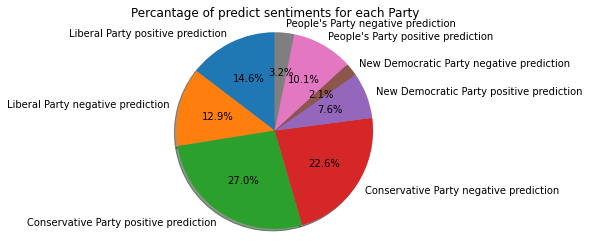

In [332]:
#visulize predict sentiment
labels = ['Liberal Party positive prediction', 'Liberal Party negative prediction', 
          'Conservative Party positive prediction', 'Conservative Party negative prediction', 
          'New Democratic Party positive prediction', 'New Democratic Party negative prediction', 
          "People's Party positive prediction", "People's Party negative prediction"]
sizes = [lib_pos_pred, lib_neg_pred, con_pos_pred, con_neg_pred, ndp_pos_pred, ndp_neg_pred, PPC_pos_pred, PPC_neg_pred]
fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  
plt.title('Percantage of predict sentiments for each Party')
plt.show()

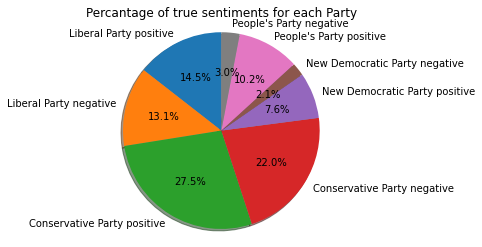

In [333]:
#visulize true sentiment
labels = ['Liberal Party positive', 'Liberal Party negative', 'Conservative Party positive', 'Conservative Party negative', 
          'New Democratic Party positive', 'New Democratic Party negative', "People's Party positive", "People's Party negative"]
sizes = [lib_pos, lib_neg, con_pos, con_neg, ndp_pos, ndp_neg, PPC_pos, PPC_neg]
fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  
plt.title('Percantage of true sentiments for each Party')
plt.show()

The predicted sentiment result has high accuracy as the true sentiment, which means the NLP analytics based on tweets is useful for political parties during election campaigns. For two major Parties, Liberal and Conservative, they have relatively equal size of positive sentiment and negative sentiment. Half of tweets loves them and the other half hates them. New Democratic Party and People's Party, however, sentiment is leaning to one side, there are more tweets like NDP and PPC than tweets that don't like them. Increase the sample size is always the most straight-forward way to improve accuracy of model.

In [342]:
#b)
nega_tw = ce_df.loc[ce_df.sentiment_num == 0]
nega_tw.negative_reason.unique()

array(['calling election early', 'covid ', 'others', 'scandal',
       'tell lies', 'gun control', 'economy', 'healthcare and marijuana',
       'segregation', 'women reproductive right and racism',
       'climate problem'], dtype=object)

In [348]:
#Encode all negative reason
nega_tw['negative_reason_encode'] = nega_tw.negative_reason.replace({'calling election early': 0, 'covid ': 1, 'others': 2, 'scandal': 3,
       'tell lies': 4, 'gun control': 5, 'economy': 6, 'healthcare and marijuana': 7,
       'segregation': 8, 'women reproductive right and racism': 9, 'climate problem': 10})
nega_tw

text sentiment  \
0     [the, canadian, election, is, a, power, grab, ...  negative   
1     [i, do, hope, trudeau, loses, the, canadian, e...  negative   
3     [canadian, friend, never, forget, that, trudea...  negative   
5     [vaccine, gun, are, key, this, election, becau...  negative   
6     [im, sorry, moderator, can, respond, but, lead...  negative   
...                                                 ...       ...   
997   [this, is, absolutely, horrible, in, canada, t...  negative   
998   [davidakin, trudeau, imposes, gun, control, po...  negative   
999   [in, canada, our, election, is, being, stolen,...  negative   
1000  [o, toole, amends, platform, on, gun, control,...  negative   
1001  [justintrudeau, stop, your, lie, stop, your, m...  negative   

             negative_reason         party  sentiment_num  predict  \
0     calling election early         Other              0        0   
1                     covid          Other              0        0   
3     calling election early           PPC              0        0   
5                     covid   Conservative              0        0   
6                     others         Other              0        0   
...                      ...           ...            ...      ...   
997                   others         Other              0        0   
998              gun control  Conservative              0        0   
999                   others         Other              0        0   
1000               tell lies  Conservative              0        0   
1001               tell lies         Other              0        0   

      negative_reason_encode  
0                          0  
1                          1  
3                          0  
5                          1  
6                          2  
...                      ...  
997                        2  
998                        5  
999                        2  
1000                       4  
1001                       4  

[387 rows x 7 columns]

In [355]:
#Set up Y data
Y_nega = nega_tw['negative_reason_encode']
#we will choose logistic regression for multi-class classification models to predict negative tweets
#bag of words feature
str_nega_sentiments = nega_tw['text'].apply(combine_list)
X_bw_nega = bag_of_words(str_nega_sentiments)
X_bw_nega

<387x2431 sparse matrix of type '<class 'numpy.int64'>'
	with 10178 stored elements in Compressed Sparse Row format>

In [356]:
#Split the negative tweets by bag of words features
X_train_bw_nega, X_test_bw_nega, y_train_bw_nega, y_test_bw_nega = train_test_split(X_bw_nega, Y_nega, test_size = 0.30, random_state = 42)

In [353]:
#TF-IDF feature
X_ti_nega = tf_idf(str_nega_sentiments)
X_ti_nega

<387x2431 sparse matrix of type '<class 'numpy.float64'>'
	with 10178 stored elements in Compressed Sparse Row format>

In [359]:
#Split the negative tweets by TF-IDF features
X_train_ti_nega, X_test_ti_nega, y_train_ti_nega, y_test_ti_nega = train_test_split(X_ti_nega, Y_nega, test_size = 0.30, random_state = 42)

# Logistic regression on negative tweets

In [362]:
#we will use default hyperparameter for the model
#Bag of words
bw_logi_nega = LogisticRegression()
bw_logi_nega.fit(X_train_bw_nega, y_train_bw_nega)
bw_logi_pred_nega = bw_logi_nega.predict(X_test_bw_nega)
bw_logi_acc_nega = accuracy_score(y_test_bw_nega, bw_logi_pred_nega)
print('The train accuracy for bag of words by logistic regression for negative tweets is', bw_logi_acc_nega)

The train accuracy for bag of words by logistic regression for negative tweets is 0.4358974358974359


In [364]:
#TF-IDF
ti_logi_nega = LogisticRegression()
ti_logi_nega.fit(X_train_ti_nega, y_train_ti_nega)
ti_logi_pred_nega = ti_logi_nega.predict(X_test_ti_nega)
ti_logi_acc_nega = accuracy_score(y_test_ti_nega, ti_logi_pred_nega)
print('The train accuracy for TF-IDF by logistic regression for negative tweets is', ti_logi_acc_nega)

The train accuracy for TF-IDF by logistic regression for negative tweets is 0.4017094017094017


a. The reason my model failed because the data is imbalanced(Training set significantly different from test set, comparison show below) and model is a little bit too complex/too many features. Reducing features can improve the accuracy of the selected model. 

In [418]:
y_train_bw_nega.value_counts(normalize=True)

2     0.396296
0     0.196296
4     0.162963
1     0.055556
5     0.044444
3     0.040741
6     0.037037
10    0.033333
7     0.014815
8     0.011111
9     0.007407
Name: negative_reason_encode, dtype: float64

In [415]:
y_test_bw_nega.value_counts(normalize=True)

2     0.358974
0     0.170940
4     0.145299
6     0.085470
1     0.085470
10    0.051282
5     0.034188
7     0.025641
3     0.025641
9     0.017094
Name: negative_reason_encode, dtype: float64

In [397]:
#c) 
#(i)bag of words for positive tweets to rank the top-50 most frequent non-stop-words
pos_tw = ce_df.loc[ce_df.sentiment_num == 1]
pos_tw

text sentiment  \
2    [dear, canadian, this, election, is, a, test, ...  positive   
4    [sorry, thejagmeetsingh, i, have, voted, ndp, ...  positive   
8    [if, canadian, voteppc, and, support, maximebe...  positive   
9    [justin, trudeau, literally, had, rock, thrown...  positive   
12   [throwbackthursday, to, federal, election, deb...  positive   
..                                                 ...       ...   
938  [this, election, is, about, canadian, freedom,...  positive   
940  [your, progressive, conservative, government, ...  positive   
943  [last, one, of, the, night, lookin, like, u, n...  positive   
969  [justintrudeau, is, killing, it, i, d, hate, t...  positive   
984  [justintrudeau, justin, rifle, dont, hurt, peo...  positive   

    negative_reason         party  sentiment_num  predict  \
2               NaN       Liberal              1        1   
4               NaN           PPC              1        1   
8               NaN           PPC              1        1   
9               NaN  Conservative              1        0   
12              NaN  Conservative              1        1   
..              ...           ...            ...      ...   
938             NaN         Other              1        1   
940             NaN  Conservative              1        1   
943             NaN  Conservative              1        1   
969             NaN         Other              1        1   
984             NaN         Other              1        1   

     negative_reason_encode  
2                       NaN  
4                       NaN  
8                       NaN  
9                       NaN  
12                      NaN  
..                      ...  
938                     NaN  
940                     NaN  
943                     NaN  
969                     NaN  
984                     NaN  

[615 rows x 7 columns]

In [421]:
from collections import Counter
#merge all text in to one big list
pos_list = []
for t in pos_tw.text:
    pos_list = pos_list + t
counts = Counter(pos_list)
#sort by frequency
most_frequency = sorted(pos_list, key=lambda x: -counts[x])
#remove duplicates
most_frequency = list(dict.fromkeys(most_frequency))
most_frequency[:50]

['the',
 'to',
 'election',
 'a',
 'and',
 'canadian',
 'for',
 'is',
 'in',
 'i',
 'this',
 'of',
 'vote',
 'you',
 'trudeau',
 'it',
 'otoole',
 'canada',
 'that',
 'on',
 'we',
 'have',
 'are',
 'will',
 'all',
 'be',
 'party',
 'he',
 's',
 'my',
 'with',
 'elxn',
 'good',
 'win',
 'if',
 'so',
 'liberal',
 'an',
 'your',
 'but',
 'get',
 'conservative',
 'federal',
 'about',
 'they',
 'like',
 'freedom',
 'not',
 'ppc',
 'our']

In [367]:
#(ii)bag of words for negative tweets to rank the top-50 most frequent non-stop-words
nega_tw

text sentiment  \
0     [the, canadian, election, is, a, power, grab, ...  negative   
1     [i, do, hope, trudeau, loses, the, canadian, e...  negative   
3     [canadian, friend, never, forget, that, trudea...  negative   
5     [vaccine, gun, are, key, this, election, becau...  negative   
6     [im, sorry, moderator, can, respond, but, lead...  negative   
...                                                 ...       ...   
997   [this, is, absolutely, horrible, in, canada, t...  negative   
998   [davidakin, trudeau, imposes, gun, control, po...  negative   
999   [in, canada, our, election, is, being, stolen,...  negative   
1000  [o, toole, amends, platform, on, gun, control,...  negative   
1001  [justintrudeau, stop, your, lie, stop, your, m...  negative   

             negative_reason         party  sentiment_num  predict  \
0     calling election early         Other              0        0   
1                     covid          Other              0        0   
3     calling election early           PPC              0        0   
5                     covid   Conservative              0        0   
6                     others         Other              0        0   
...                      ...           ...            ...      ...   
997                   others         Other              0        0   
998              gun control  Conservative              0        0   
999                   others         Other              0        0   
1000               tell lies  Conservative              0        0   
1001               tell lies         Other              0        0   

      negative_reason_encode  
0                          0  
1                          1  
3                          0  
5                          1  
6                          2  
...                      ...  
997                        2  
998                        5  
999                        2  
1000                       4  
1001                       4  

[387 rows x 7 columns]

In [422]:
neg_list = []
for t in nega_tw.text:
    neg_list = neg_list + t
counts = Counter(neg_list)
#sort by frequency
most_frequency = sorted(neg_list, key=lambda x: -counts[x])
#remove duplicates
most_frequency = list(dict.fromkeys(most_frequency))
most_frequency[:50]

['the',
 'a',
 'election',
 'to',
 'is',
 'canadian',
 'and',
 'of',
 'in',
 'he',
 'trudeau',
 'for',
 'this',
 'you',
 'i',
 'otoole',
 'that',
 'an',
 'it',
 'are',
 'on',
 'canada',
 'not',
 'have',
 's',
 'will',
 'be',
 't',
 'with',
 'but',
 'his',
 'about',
 'we',
 'they',
 'pandemic',
 'just',
 'vote',
 'ha',
 'justintrudeau',
 'elxn',
 'like',
 'so',
 'all',
 'at',
 'if',
 'conservative',
 'what',
 'no',
 'liberal',
 'party']

The top-50 most frequent non-stop-words are pretty much the same. Most negative tweets and positive tweets are about Liberal Party and Conservative Party as well as their leaders. Except, 'freedom' seems like a common word for positive tweets and 'pandemic' is the common word for negative tweets.